# adult dataset 

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceFunctionEval,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)

from opendataval.experiment import ExperimentMediator

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: adult
- Model: sklearn's logistic regression model
- Metric: Classification accuracy

In [2]:
dataset_name = "adult"
train_count, valid_count, test_count = 1000, 100, 500
noise_rate = 0.2
noise_kwargs = {'noise_rate': noise_rate}
model_name = "sklogreg"
metric_name = "accuracy"

exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir="../data_files/",  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=mix_labels, 
    noise_kwargs=noise_kwargs,
    train_kwargs={},
    model_name=model_name,
    metric_name=metric_name
)

Base line model metric_name='accuracy': perf=0.8080000281333923


A full list of registered datasets can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/dataloader/fetcher.py#L121). A list of available  prediction models can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/model/__init__.py#L111).

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [3]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceFunctionEval(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
    DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley
    BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley
    DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(),
    RobustVolumeShapley(mc_epochs=300)
]

In [4]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.000600


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.51it/s]


Elapsed time LeaveOneOut(): 0:00:19.438599


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.30it/s]


Elapsed time InfluenceFunctionEval(num_models=1000): 0:00:14.646423


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.36it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:37.915869


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 11382.89it/s]

Elapsed time KNNShapley(k_neighbors=100): 0:00:00.902661
Start: marginal contribution computation



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.64it/s]


gr_stat=100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


gr_stat=100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.62it/s]

gr_stat=1.0312307123928959
Done: marginal contribution computation


Elapsed time DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached): 0:03:02.210530
Elapsed time BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached): 0:00:00.003165


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.50it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:11.584858


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.69it/s]


Elapsed time AME(num_models=1000): 0:00:44.348298


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.22it/s]


Elapsed time DataOob(num_models=1000): 0:00:22.622481


Elapsed time LavaEvaluator(): 0:00:01.064159


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 55.80it/s]

Elapsed time RobustVolumeShapley(mc_epochs=300): 0:00:05.381148
CPU times: user 5min 6s, sys: 1.82 s, total: 5min 8s
Wall time: 5min 40s


## [Step 3] Evaluate data values

In [5]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/adult_noise_rate=0.2/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [6]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.264615
"BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached)",0.483871
DVRL(rl_epochs=2000),0.482115
DataBanzhaf(num_models=1000),0.311321
DataOob(num_models=1000),0.596050
"DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached)",0.478161
InfluenceFunctionEval(num_models=1000),0.313972
KNNShapley(k_neighbors=100),0.577617
LavaEvaluator(),0.045662
LeaveOneOut(),0.305253


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

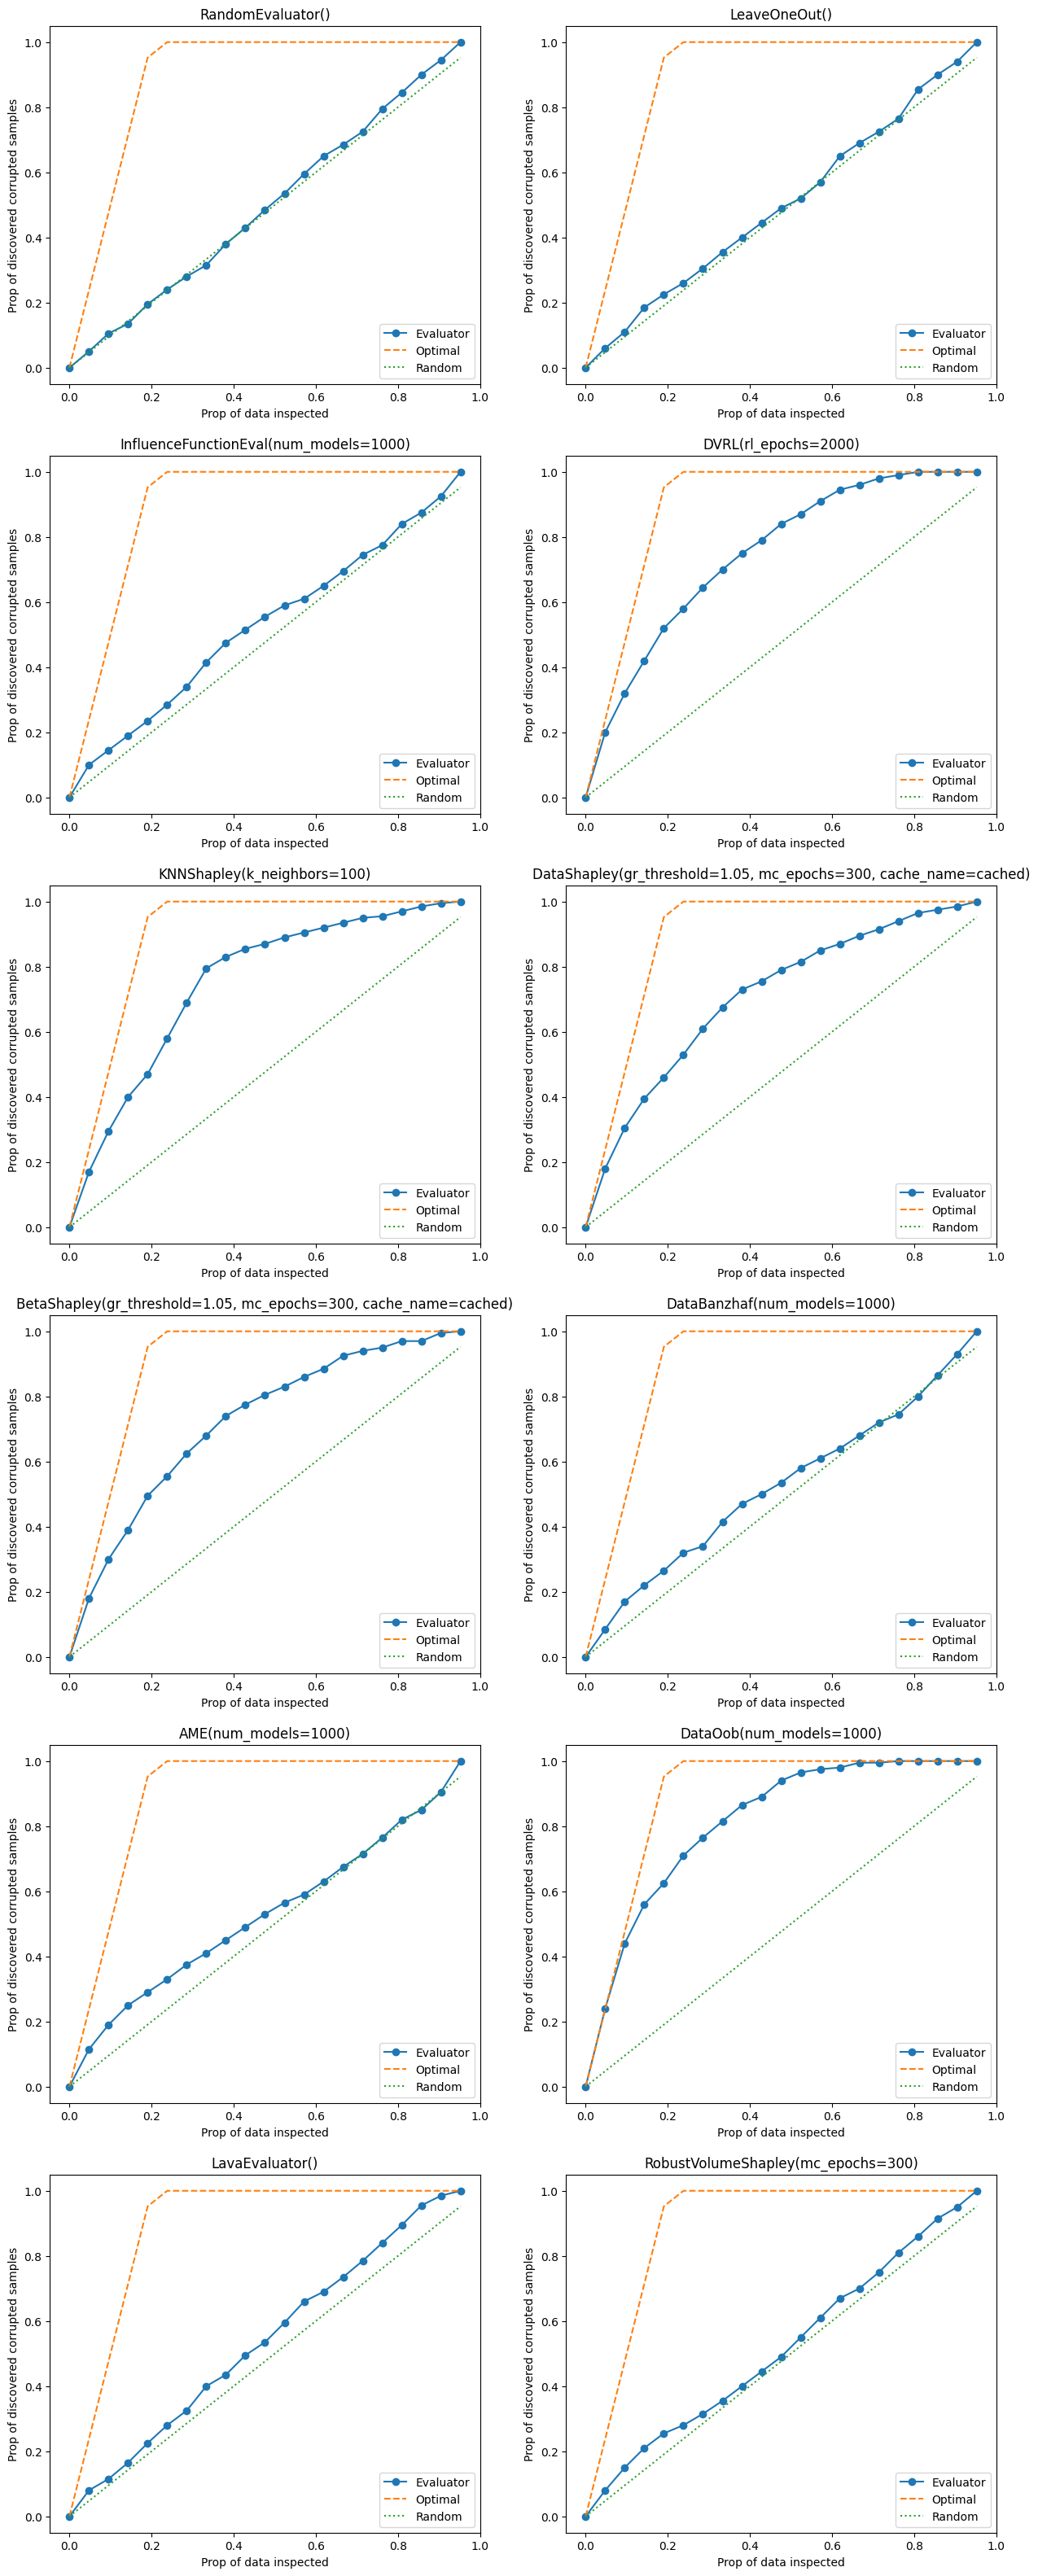

In [7]:
fig = plt.figure(figsize=(15, 40))
df, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

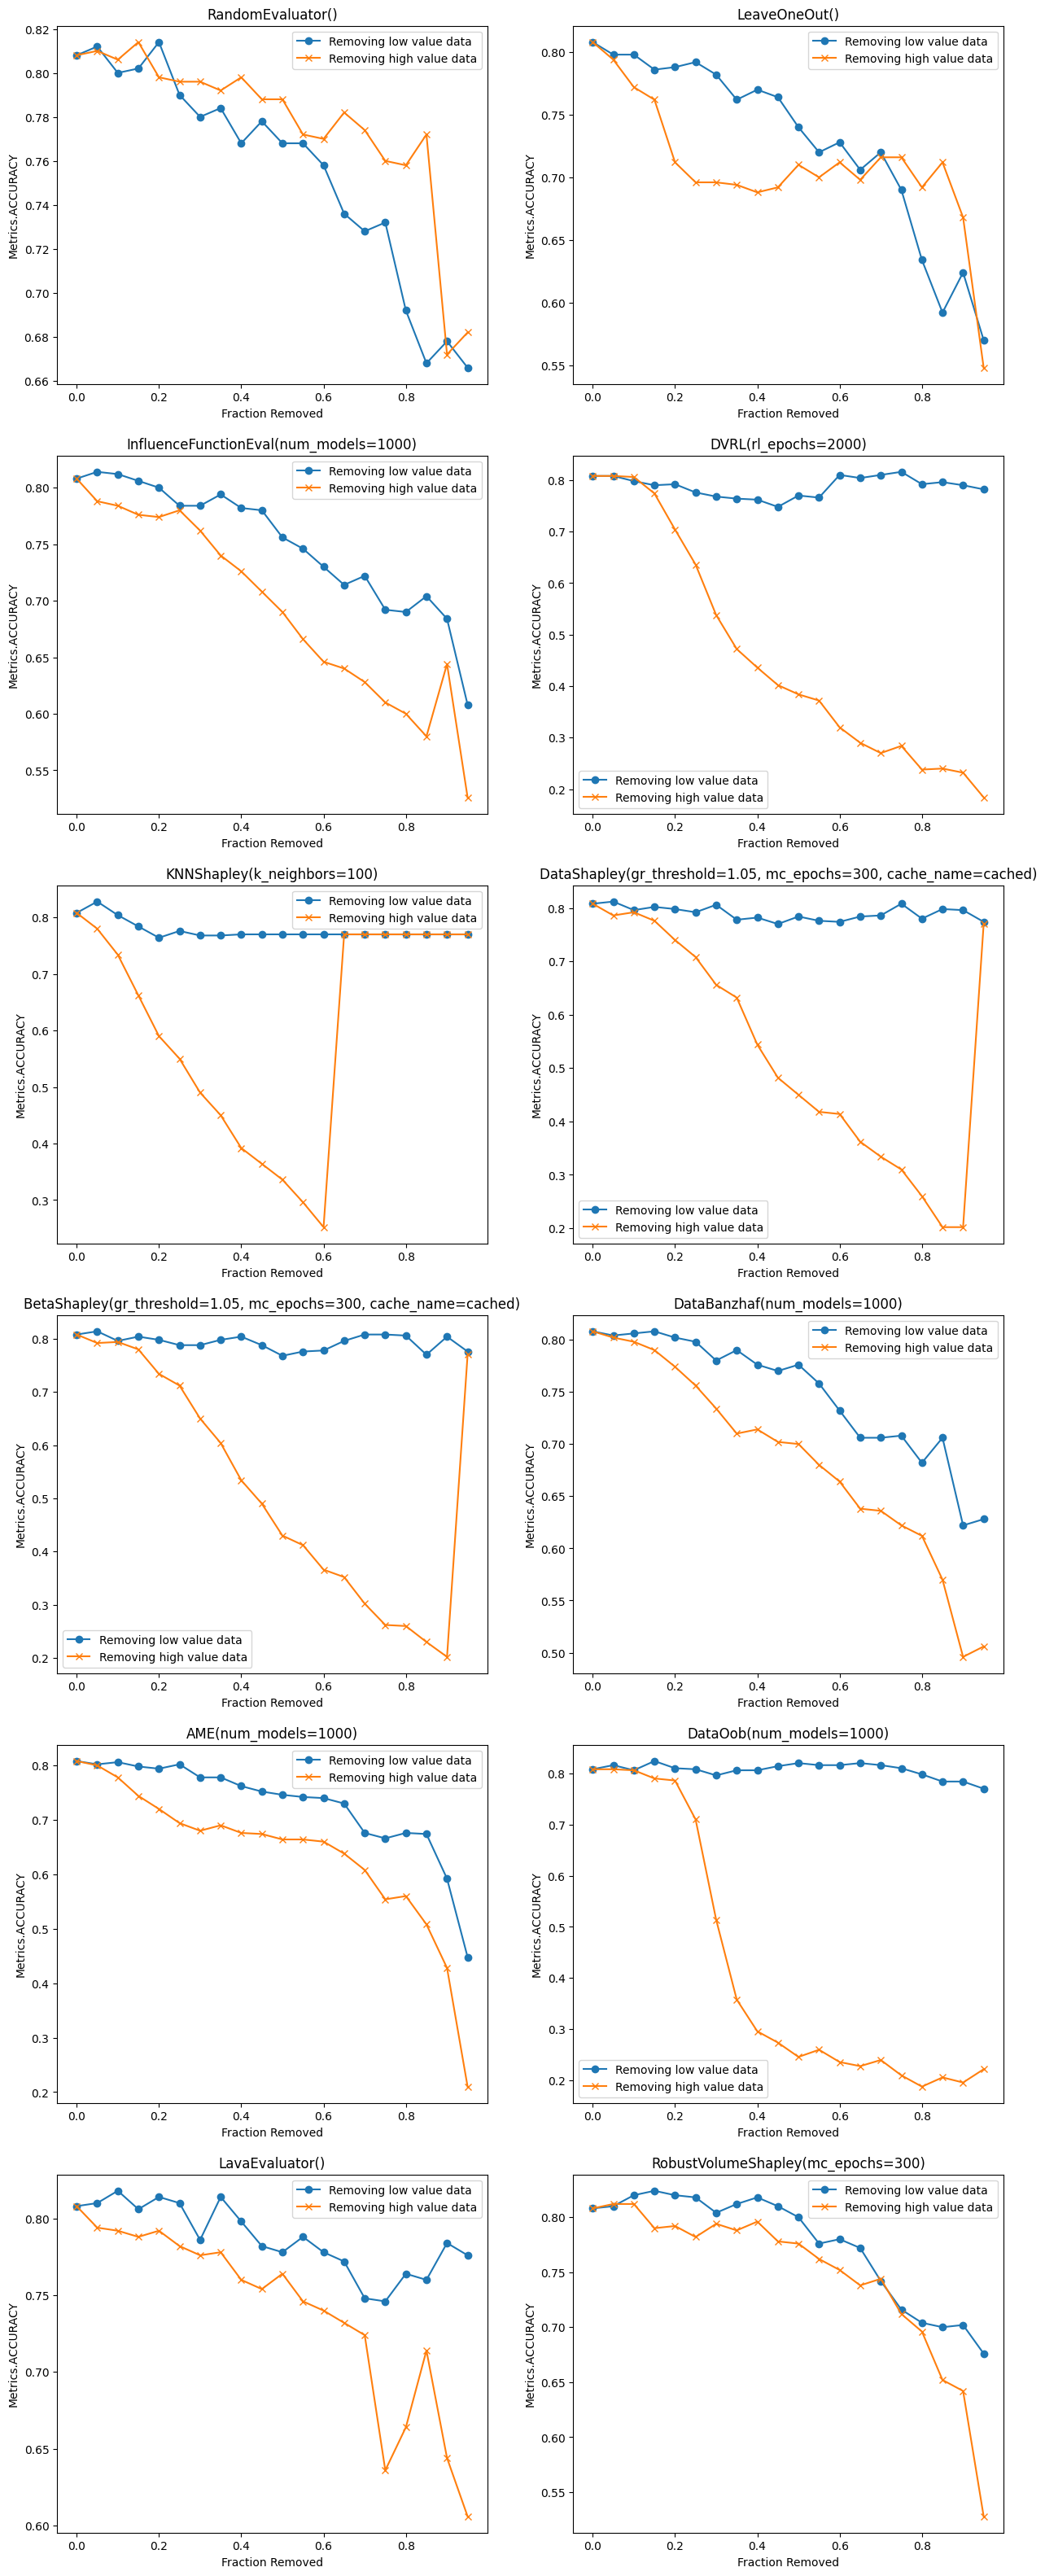

In [8]:
fig = plt.figure(figsize=(15, 40))
df_resp, fig = exper_med.plot(remove_high_low, fig, include_train=True, col=2, save_output=True)

In [9]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.ACCURACY,remove_most_influential_first_Metrics.ACCURACY,axis
RandomEvaluator(),0.808,0.808,0.0
RandomEvaluator(),0.812,0.81,0.05
RandomEvaluator(),0.8,0.806,0.1
RandomEvaluator(),0.802,0.814,0.15
RandomEvaluator(),0.814,0.798,0.2
...,...,...,...
RobustVolumeShapley(mc_epochs=300),0.716,0.712,0.75
RobustVolumeShapley(mc_epochs=300),0.704,0.696,0.8
RobustVolumeShapley(mc_epochs=300),0.7,0.652,0.85
RobustVolumeShapley(mc_epochs=300),0.702,0.642,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [10]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),13484,0.343242
RandomEvaluator(),19837,0.262725
RandomEvaluator(),20012,0.348603
RandomEvaluator(),19844,0.48592
RandomEvaluator(),23137,0.38239
...,...,...
RobustVolumeShapley(mc_epochs=300),30968,0.0
RobustVolumeShapley(mc_epochs=300),2477,0.0
RobustVolumeShapley(mc_epochs=300),2325,0.0
RobustVolumeShapley(mc_epochs=300),22820,0.0
